# Segment Anything - Experiments
We believe that the abilities of the released foundation model, **Segment Anything Model** (*SAM*), can serve the purpose of creating a *generalizable object-centric representation* model. Indeed, its capacity to segment any object into images in a zero-shot manner would permit to serve as a powerful prior for object discovery.

That's why we want to experiment with it, to see how we can leverage its knowledge to train new models through *knowledge distillation* later on.

## Import librairies

In [2]:
# Import all the packages needed for the project 
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from expe.dataset import YCBDataset
from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import sys

using_colab = False

## Utility functions
We first define some utility functions to visualize the masks, points and boxes around objects.

In [3]:
def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Load model
Three different size of checkpoints are available for the model. In our experiments, we will use the default size (ViT-H). 

In [4]:
sys.path.append("..")

device = "cuda"
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device=device)

# Defining a predictor and a mask generator
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

## Create the datasets
For our experiments, we will test the abilities of *SAM* on several real world objects dataset. This could permit us to confirm if it could be correctly used to be deployed in such a scenario. 

The **YCB-Video** dataset used for 6D pose estimation seems to be a good starting point to evaluate the *zero-shot segmentation capabilities* of the model. It is compose of thousands of images containing 21 different objects in 80 different scenes with different viewpoints.

The **ARMBench** dataset is a perception and manipulation benchmark in a robotic pick-and-place setting. It contains several scenes with different objects and different challenges such as Object segmentation, Object Identification, and Defect Detection on images and videos.

To handle the data from these datasets, we created custom Pytorch Dataset classes. 

In [7]:
dataset_ycb = YCBDataset("./../../Datasets/ycb-video/image_sets/train.txt", "./../../Datasets/ycb-video/data")
dataloader_ycb = DataLoader(dataset, batch_size=16, shuffle=True)

dataset_arm = ARMDataset("", "")
dataloader_arm = DataLoader(dataset, batch_size=16, shuffle=True)

## Experiments on images
In this section, we will experiment several things on randomly sampled images from YCB-Video dataset. 

### Show images
We first show some random images to see how they look.

(3, 480, 640)


TypeError: Invalid shape (3, 480, 640) for image data

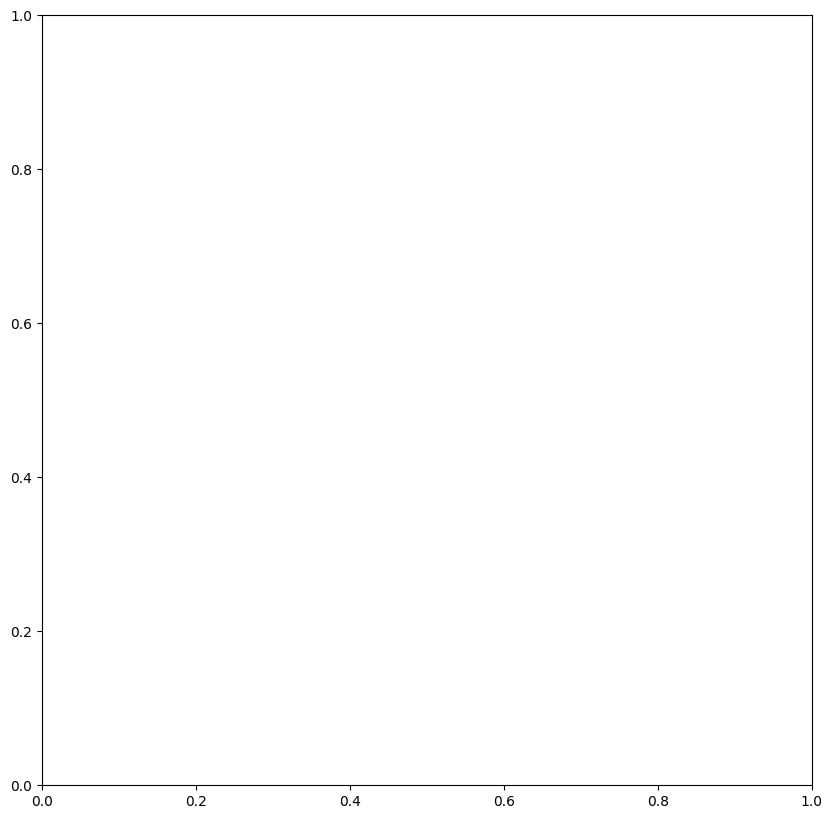

In [10]:
# Get some images
images_ycb =  list(enumerate(dataloader_ycb))[:5]
images_arm =  list(enumerate(dataloader_arm))[:5]

# Show the images
for image in images_ycb:
    np_img = np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(np_img)
    plt.show() 
    
for image in images_arm:
    np_img = np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(np_img)
    plt.show() 

## Predict masks with points
In the following section, we will experiment the ability of *SAM* to segment objects with a Point prompt and see how it can handle ambiguities.

A Point prompt is in the format (x, y) and is given with a label 1 (for foreground) and 0 (for background).


In [ ]:
# Prompt point and label
input_point = np.array([[500, 375]])
input_label = np.array([1])

# Show point on some images
for image in im:
    np_img = np.array(image)
    predictor.set_image(np_img)

    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show() 

We will now show what the model predicts for the given prompt. It should return masks and a confidence score (quality prediction) but also a low resolution mask logits that can be used for the next iteration.

In [ ]:
# Predict the masks
for image in im:
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

We can also use multiple points to handle a single object like in the following :

There also exist negative points that permits to exclude some parts from the segmentation :

## Predict mask with box
In the following, we will experiment the capabilities of *SAM* to segment objects with a box prompt. We will first give it manual prompt and then try to combine it with the prediction of a YOLO model.